In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
sys.path.append("/local/storage/ly349/projects/Deconvolution/Notebooks/")
from utils import get_bioqueue_file

In [ ]:
def agg_func(job_dict):
    eval_res = []
    for k, v in job_dict.items():
        for cond_idx, (matched_eval_file, unmatched_eval_file) in enumerate(v):
            m_res_df = pd.read_csv(matched_eval_file)
            assert all([c in m_res_df.columns for c in ("Transform", "Model", "CCC")]), matched_eval_file
            m_agg_res_df = m_res_df.loc[
                m_res_df["Transform"]=="log", 
                ["Model", "CCC"]
            ].groupby("Model").agg("median")
            
            um_res_df = pd.read_csv(unmatched_eval_file)
            assert all([c in m_res_df.columns for c in ("Transform", "Model", "CCC")]), unmatched_eval_file
            um_agg_res_df = um_res_df.loc[
                um_res_df["Transform"]=="log", 
                ["Model", "CCC"]
            ].groupby("Model").agg("median")
    
            cond_df = m_agg_res_df.join(um_agg_res_df, lsuffix="_matched", rsuffix="_unmatched", how="inner").reset_index()
            cond_df["Dataset"] = k
            cond_df["Condition"] = cond_idx
            eval_res.append(cond_df)
    return pd.concat(eval_res)

In [5]:
state_eval_jobs = {
    "5D1": (  # reference and bulk have cell types in different states
        ( # scenario 1: HCT116 perturbed
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:29833-v0.2.0-PROcap-5D1-OOD2_HCT116-eval.csc.csv.gz}}"),
        ),
    ),
    "5D2": (
        ( # scenario 2: healthy epithelial cell to deconvolve cancerous epithelial cell
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:29867-v0.2.0-PROcap-5D1-OOD3_MCF10T7-eval.csc.csv.gz}}"),
        ),
    )
}

In [6]:
biorep_eval_jobs = {
    "5D1": (  # references are made by libraries from different batches (tech/biological variation)
        (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:30849-v0.2.0-PROcap-5D1-KAreplacement-eval.csc.csv.gz}}"),
        ),
    ),
    "5D2": (
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:30850-v0.2.0-PROcap-5D2-MAreplacement-eval.csc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:30851-v0.2.0-PROcap-5D2-GAreplacement-eval.csc.csv.gz}}"),
        )
    ),
}

In [7]:
qualitymism_eval_jobs = {
    "5D1": (  # references are made by libraries from different batches (tech/biological variation)
        (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:30819-v0.2.0-PROcap-5D1-HQxMQ-eval.csc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:30820-v0.2.0-PROcap-5D1-MQxHQ-eval.csc.csv.gz}}"),
        ),
    ),
    "5D2": (
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:30821-v0.2.0-PROcap-5D2-HQxMQ-eval.csc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.csc.csv.gz}}"),
            get_bioqueue_file("{{History:30822-v0.2.0-PROcap-5D2-MQxHQ-eval.csc.csv.gz}}"),
        )
    ),
}

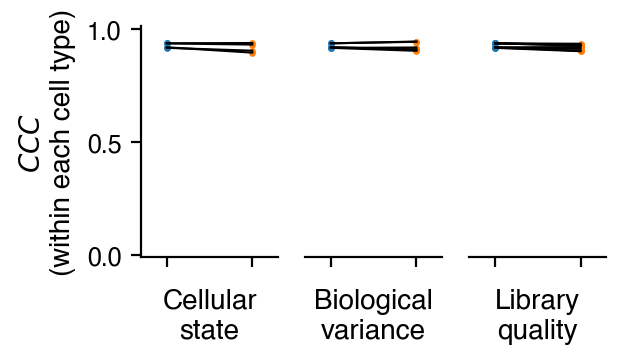

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3, 1.5), sharex=True, sharey=True)

ax = axs[0]
sub_df = agg_func(state_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)

for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", ""])
ax.set_xlabel("Cellular\nstate")

ax = axs[1]
sub_df = agg_func(biorep_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
sub_df.columns = [0, 1]
ind = np.arange(2)
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", ""])
ax.set_xlabel("Biological\nvariance")

ax = axs[2]
sub_df = agg_func(qualitymism_eval_jobs)[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
deltas = np.zeros(sub_df.shape[0])
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
        deltas[nr] = row[prev] - row[c]
plt.xticks(ind, ["", ""])
ax.set_xlabel("Library\nquality")

for i, ax in enumerate(axs):
    ax.set_xlim((-0.3, 1.3))
    ax.set_ylim((-0.01, 1.01))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if i > 0:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False)
    else:
        ax.set_ylabel(r"$CCC$"+"\n(within each cell type)")

In [9]:
state_eval_jobs = {
    "5D1": (  # reference and bulk have cell types in different states
        ( # scenario 1: HCT116 perturbed
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:29833-v0.2.0-PROcap-5D1-OOD2_HCT116-eval.crc.csv.gz}}"),
        ),
    ),
    "5D2": (
        ( # scenario 2: healthy epithelial cell to deconvolve cancerous epithelial cell
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:29867-v0.2.0-PROcap-5D1-OOD3_MCF10T7-eval.crc.csv.gz}}"),
        ),
    )
}
biorep_eval_jobs = {
    "5D1": (  # references are made by libraries from different batches (tech/biological variation)
        (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:30849-v0.2.0-PROcap-5D1-KAreplacement-eval.crc.csv.gz}}"),
        ),
    ),
    "5D2": (
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:30850-v0.2.0-PROcap-5D2-MAreplacement-eval.crc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:30851-v0.2.0-PROcap-5D2-GAreplacement-eval.crc.csv.gz}}"),
        )
    ),
}
qualitymism_eval_jobs = {
    "5D1": (  # references are made by libraries from different batches (tech/biological variation)
        (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:30819-v0.2.0-PROcap-5D1-HQxMQ-eval.crc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:20198-v0.2.0-5D1-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:30820-v0.2.0-PROcap-5D1-MQxHQ-eval.crc.csv.gz}}"),
        ),
    ),
    "5D2": (
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:30821-v0.2.0-PROcap-5D2-HQxMQ-eval.crc.csv.gz}}"),
        ),
        (
            get_bioqueue_file("{{History:20199-v0.2.0-5D2-PROcap-eval.crc.csv.gz}}"),
            get_bioqueue_file("{{History:30822-v0.2.0-PROcap-5D2-MQxHQ-eval.crc.csv.gz}}"),
        )
    ),
}

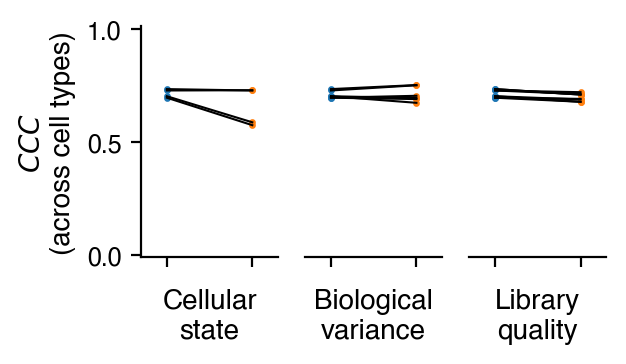

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(3, 1.5), sharex=True, sharey=True)
ax = axs[0]
sub_df = agg_func(state_eval_jobs, "median")[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)

for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", ""])
ax.set_xlabel("Cellular\nstate")

ax = axs[1]
sub_df = agg_func(biorep_eval_jobs, "median")[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
sub_df.columns = [0, 1]
ind = np.arange(2)
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
plt.xticks(ind, ["", ""])
ax.set_xlabel("Biological\nvariance")

ax = axs[2]
sub_df = agg_func(qualitymism_eval_jobs, "median")[["CCC_matched", "CCC_unmatched"]].copy().reset_index(drop=True)
ind = np.arange(sub_df.shape[1])
for i in sub_df.columns:
    ax.scatter(np.repeat(i, len(sub_df[i])), sub_df[i], s=2)
deltas = np.zeros(sub_df.shape[0])
for nr, row in sub_df.iterrows():
    for index, c in enumerate(sub_df.columns):
        if index == 0:
            continue
        prev = sub_df.columns[index - 1]
        ax.plot(
            (prev, c), (row[prev], row[c]), 
            linewidth=0.75, color="black"
        )
        deltas[nr] = row[prev] - row[c]
plt.xticks(ind, ["", ""])
ax.set_xlabel("Library\nquality")

for i, ax in enumerate(axs):
    ax.set_xlim((-0.3, 1.3))
    ax.set_ylim((-0.01, 1.01))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    if i > 0:
        ax.spines["left"].set_visible(False)
        ax.tick_params(axis="y", left=False)
    else:
        ax.set_ylabel(r"$CCC$"+"\n(across cell types)")